# Mean Curvature Flow

Mean curvature flow is a specific example of a geometric evolution
equation where the evolution is governed by the mean curvature $H$.
One real-life example of this is in how soap films change over time,
although it can also be applied to image processing (e.g.
:cite:`Malladi`).
Assume we can define a reference surface $\Gamma_0$ such that
we can write the evolving surface $\Gamma(t)$ in the form
\begin{gather*}
\Gamma(t) = X(t,\Gamma_0).
\end{gather*}
It is now possible to show that the vector valued function $X=X(t,x)$
with $x\in\Gamma_0$ satisfies
\begin{gather*}
\frac{\partial}{\partial_t}X = - H(X)\nu(X),
\end{gather*}
where $H$ is the mean curvature of $\Gamma_t$ and $\nu$ is its outward pointing normal.

We will solve this using a finite element approach based on the
following time discrete approximation from :cite:`Charlie`
(with a $\theta$-scheme applied).
\begin{align*}
\int_{\Gamma^n} \big( U^{n+1} - {\rm id}\big) \cdot \varphi +
    \tau \int_{\Gamma^n} \big(
    \theta\nabla_{\Gamma^n} U^{n+1} + (1-\theta) I \big)
    \colon\nabla_{\Gamma^n}\varphi
  =0.
\end{align*}
Here $U^n$ parametrizes $\Gamma(t^{n+1})$ over
$\Gamma^n:=\Gamma(t^{n})$, $I$ is the identity matrix, $\tau$ is the
time step and $\theta\in[0,1]$ is a discretization parameter.
<img src="mcf.gif" style="height:228px;">

In [1]:
import matplotlib
matplotlib.rc( 'image', cmap='jet' )
import math

from ufl import *
from dune.ufl import Constant
import dune.ufl
import dune.geometry as geometry
import dune.fem as fem
from dune.fem.plotting import plotPointData as plot
import matplotlib.pyplot as pyplot
from IPython import display

set up polynomial order and radius of reference surface

In [2]:
order = 2
R0 = 2.

We begin by setting up reference domain $\Gamma_0$ (```grid```), and the space on $\Gamma_0$ that describes $\Gamma(t)$ (```space```). From this we interpolate the non-spherical initial surface ```positions```, and, then reconstruct ```space``` for the discrete solution on $\Gamma(t)$.

In [3]:
from dune.fem.view import geometryGridView
from dune.fem.space import lagrange as solutionSpace
from dune.alugrid import aluConformGrid as leafGridView
gridView = leafGridView("sphere.dgf", dimgrid=2, dimworld=3)
space = solutionSpace(gridView, dimRange=gridView.dimWorld, order=order)
u = TrialFunction(space)
v = TestFunction(space)
x = SpatialCoordinate(space)
positions = space.interpolate(x * (1 + 0.5*sin(2*pi*x[0]*x[1])* cos(pi*x[2])), name="position")
surface = geometryGridView(positions)
space = solutionSpace(surface, dimRange=surface.dimWorld, order=order)
solution = space.interpolate(x, name="solution")

We set up the theta scheme with $\theta = 0.5$ (Crank-Nicholson).

In [4]:
from dune.fem.scheme import galerkin as solutionScheme
theta = 0.5
I = Identity(3)
dt = Constant(0, "dt")

a = (inner(u - x, v) + dt * inner(theta*grad(u) + (1 - theta)*I, grad(v))) * dx
scheme = solutionScheme(a == 0, space, solver="cg")

Now we solve the scheme in time. We first set up the initial time variables, then we plot the initial figure's mesh, and finally we begin the loop, updating ```positions``` on each step and plotting the results side-by-side.

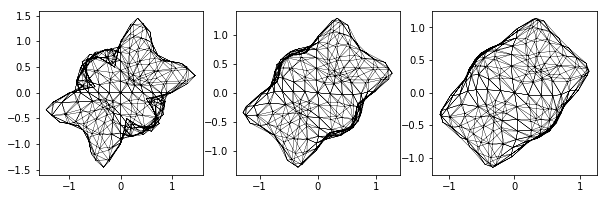

In [5]:
count = 0
t = 0.
end_time = 0.05
scheme.model.dt = 0.005

fig = pyplot.figure(figsize=(10, 10))
plot(solution, figure=(fig, 131+count%3), colorbar=False,
     gridLines="", triplot=True)

while t < end_time:
    scheme.solve(target=solution)
    t += scheme.model.dt
    count += 1
    positions.dofVector.assign(solution.dofVector)
    if count % 4 == 0:
        plot(solution, figure=(fig, 131+count%3), colorbar=False,
             gridLines="", triplot=True)
pyplot.show()
pyplot.close('all')

In case we start with a spherical initial surface, i.e., $\Gamma(0)=R_0\;S^2$, the solution
to the mean curvature flow equation is easy to compute:
\begin{align*}
\Gamma(t) &= R(t)\;S^2 \\
R(t) &= \sqrt{R_0^2-4t}
\end{align*}
We can use this to check that our implementation is correct. To do so we first define a function that computes the averaged radius of the surface.

In [6]:
def calcRadius(surface):
    # compute R = int_x |x| / int_x 1
    R   = 0
    vol = 0
    for e in surface.elements:
        rule = geometry.quadratureRule(e.type, 4)
        for p in rule:
            geo = e.geometry
            weight = geo.volume * p.weight
            R   += geo.toGlobal(p.position).two_norm * weight
            vol += weight
    return R/vol

Now we test the convergence rate by solving over a loop, and calculating the error in terms of the difference between the above analytical solution and our calculated one. We plot this in a figure.

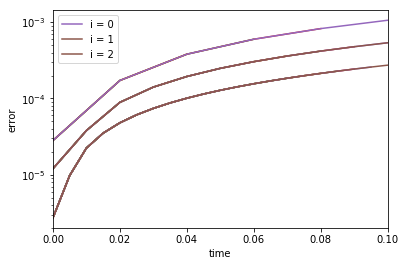

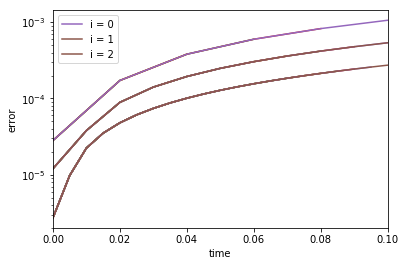

In [7]:
end_time = 0.1
scheme.model.dt = 0.02

import numpy as np
pyplot.figure()
pyplot.gca().set_xlim([0, end_time])
pyplot.gca().set_ylabel("error")
pyplot.gca().set_xlabel("time")

number_of_loops = 3
errors = np.zeros(number_of_loops)
totalIterations = np.zeros(number_of_loops, np.dtype(np.uint32))
gridSizes = np.zeros(number_of_loops, np.dtype(np.uint32))
for i in range(number_of_loops):
    positions.interpolate(x * (R0/sqrt(dot(x,x))))
    solution.interpolate(x)
    t = 0.
    R = calcRadius(surface)
    Rexact = math.sqrt(R0**2 - 4.*t)
    tvec = np.array([t])
    evec = np.array([abs(R - Rexact)])
    iterations = 0
    while t < end_time:
        info = scheme.solve(target=solution)
        # move the surface
        positions.dofVector.assign(solution.dofVector)
        # store some information about the solution process
        iterations += int( info["linear_iterations"] )
        t += scheme.model.dt
        R = calcRadius( surface )
        Rexact = math.sqrt(R0*R0-4.*t)
        tvec = np.append(tvec, [t])
        evec = np.append(evec, [abs(R - Rexact)])
        pyplot.semilogy(tvec, evec, label='i = '+ str(i) if t >= end_time                     else '')
        pyplot.legend()
        display.clear_output(wait=True)
        display.display(pyplot.gcf())
    errors[i] = abs(R - Rexact)
    totalIterations[i] = iterations
    gridSizes[i] = gridView.size(2)
    if i < number_of_loops - 1:
        gridView.hierarchicalGrid.globalRefine(1)
        scheme.model.dt /= 2

The estimated orders of convergence (EOCs) are calculated as shown.

In [8]:
eocs = np.log(errors[0:][:number_of_loops-1] / errors[1:]) / math.log(math.sqrt(2.)) # note: ALUConform only bisects

Finally we organise this information into a table using ```pandas```.

In [9]:
try:
    import pandas as pd
    keys = {'size': gridSizes, 'error': errors,
            "eoc": np.insert(eocs, 0, None),
            'iterations': totalIterations}
    table = pd.DataFrame(keys, index=range(number_of_loops),
                         columns=['size', 'error', 'eoc',
                                  'iterations'])
    print(table)
except ImportError:
    print("pandas could not be used to show table with results")
    pass

   size     error       eoc  iterations
0   318  0.001060       NaN          94
1   854  0.000599  1.647357         390
2  2065  0.000273  2.262345         895
